In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx
import matplotlib.pyplot as plt

c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%run -i simulator.py

In [3]:
p = 3
q = 2
N = 20

simulator = GRDPG(p, q, N)

In [4]:
A = simulator.sample_Beta(1/2, 1)

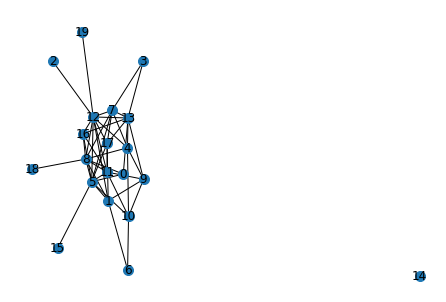

In [6]:
g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

# Example of simulation from the Block model

In [7]:
%run -i simulator.py

In [8]:
Ncommunities = 10

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))

# print(np.round(B.numpy(), 2))

In [9]:
N = 100
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

# print(E.numpy())

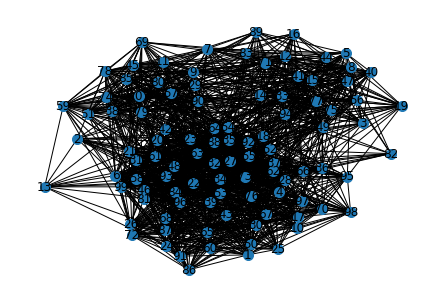

In [10]:
A = simulator.sample(E)

g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

In [11]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)
newsimulator = GRDPG(p, q, N)

Xminus = X*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

M    = tf.einsum("kj,nj->nk", tf.einsum("nk,kj->nj", E, B), E)
newM = tf.einsum("ik,jk->ij", Xminus, X)

newB = tf.linalg.matmul(tf.linalg.matmul(eigenvect_eigenval, tf.linalg.diag(newsimulator.I)), tf.transpose(eigenvect_eigenval))

print("there are "+str(q)+" negative eigenvalues.")
print("we recover B: "+str(tf.reduce_all(tf.abs(B-newB)<1e-5).numpy()))
print("we recover M: "+str(tf.reduce_all(tf.abs(M-newM)<1e-5).numpy()))

there are 2 negative eigenvalues.
we recover B: True
we recover M: True


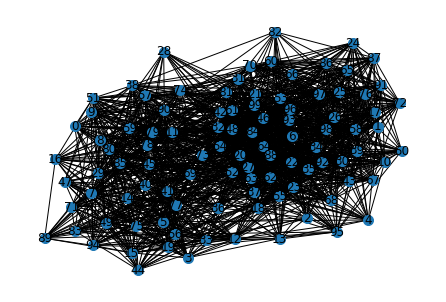

In [12]:
newsimulator = GRDPG(p, q, N)

A = newsimulator.sample(X)
g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

# Spectral embedding 

In [25]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.51593006, 0.04917296],
       [0.04917296, 0.51607454]], dtype=float32)>

In [28]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.38578881, 0.61421119])>

In [29]:
N = 2000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

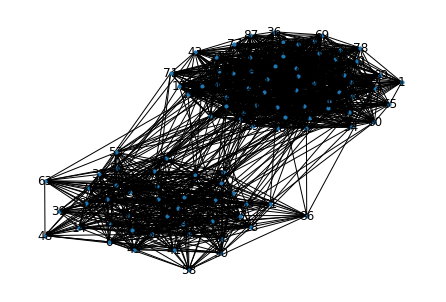

In [30]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [31]:
def d_spectral(A, d):

    eigenvalues, eigenvectors = tf.linalg.eig(A)

    eigenvalues  = tf.math.real(eigenvalues )
    eigenvectors = tf.math.real(eigenvectors)

    eigenvalues  = eigenvalues[-d:]
    eigenvectors = eigenvectors[:,-d:]

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", eigenvectors_sort, tf.sqrt(tf.abs(eigenvalues_sort)))

In [32]:
d = 2
p, q, hatX = d_spectral(A, d)

In [33]:
newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.116523564


# Spectral embedding- TensorLy

In [9]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 1/2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5000219 , 0.08184854],
       [0.08184854, 0.500124  ]], dtype=float32)>

In [10]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.33519915, 0.66480085])>

In [11]:
N = 4000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

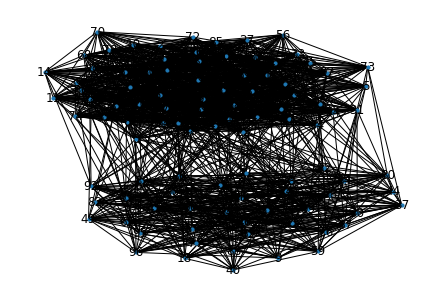

In [12]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [13]:
import tensorly

def d_spectral_tensorly(A, d):

    eigenvectors, eigenvalues, _ = tensorly.partial_svd(A, n_eigenvecs=d)

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", eigenvectors_sort, tf.sqrt(tf.abs(eigenvalues_sort)))

In [14]:
d = 2
p, q, hatX = d_spectral_tensorly(A, d)

newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.087658584


# Weighted bootstrap

In [21]:
Ncommunities = 2

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5217734 , 0.05141697],
       [0.05141697, 0.6283517 ]], dtype=float32)>

In [22]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.62311572, 0.37688428])>

In [23]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

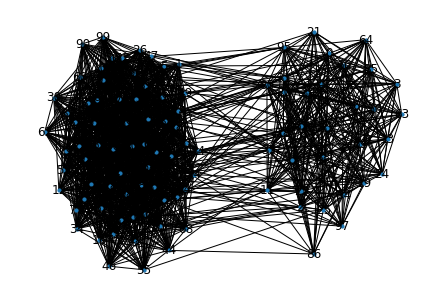

In [24]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [25]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [26]:
W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
bigA = W*A

In [27]:
bigA.shape

TensorShape([1000, 1000])

In [34]:
# def weighted_bootstrap(iterations, A, d):

#     p_list = []
#     q_list = []
#     hatX_list = []

#     for i in range(iterations):

#         W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
#         p, q, hatX = d_spectral_tensorly(W*A, d)

#         p_list.append(p)
#         q_list.append(q)
#         hatX_list.append(hatX)

#     return p_list, q_list, hatX_list

def weighted_bootstrap(iterations, A, d):
    
    W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
    bigA = W*A

    for i in range(1, iterations):

        W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
        bigA = tf.concat((bigA, W*A), axis = 0)

    p, q, hatX = d_spectral_tensorly(bigA, d)

    return p, q, hatX

In [43]:
iterations = 100
d = 2

p, q, hatXcombined = weighted_bootstrap(iterations, A, d)


In [44]:
# i = 0

# p, q, hatX = p_list[i], q_list[i], hatX_list[i]
# newsimulator = GRDPG(p, q, N)
# hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
# hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

# hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

# for i in range(1, iterations):

#     p, q, hatX = p_list[i], q_list[i], hatX_list[i]
#     newsimulator = GRDPG(p, q, N)
#     hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
#     hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

#     hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

#     hatMsample = tf.concat((hatMsample, hatM), axis = 2)

i = 0

hatX = hatXcombined[i*N:(i+1)*N,:]
newsimulator = GRDPG(p, q, N)
hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

for i in range(1, iterations):

    hatX = hatXcombined[i*N:(i+1)*N,:]
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

    hatMsample = tf.concat((hatMsample, hatM), axis = 2)



In [50]:
hatMsample

<tf.Tensor: shape=(1000, 1000, 100), dtype=float32, numpy=
array([[[0.05886493, 0.05414006, 0.05278224, ..., 0.06168389,
         0.06493031, 0.04427475],
        [0.00651827, 0.00568127, 0.00491122, ..., 0.00433896,
         0.00522302, 0.00348823],
        [0.05831493, 0.05766296, 0.05508896, ..., 0.0648637 ,
         0.06394473, 0.05119056],
        ...,
        [0.00497768, 0.00565234, 0.00623552, ..., 0.00482847,
         0.00473734, 0.00545246],
        [0.00452308, 0.00353747, 0.00487679, ..., 0.00359203,
         0.00537247, 0.00403066],
        [0.00477468, 0.00523886, 0.00577458, ..., 0.00515376,
         0.00598195, 0.00367968]],

       [[0.00651827, 0.00568127, 0.00491122, ..., 0.00433896,
         0.00522302, 0.00348823],
        [0.04477844, 0.05754143, 0.06768262, ..., 0.05530006,
         0.05080058, 0.05240458],
        [0.00522793, 0.00502029, 0.00380004, ..., 0.00442976,
         0.00518545, 0.00326629],
        ...,
        [0.04755057, 0.04864384, 0.06000844, ...,

In [45]:
# i = 0

# p, q, hatX = p_list[i], q_list[i], hatX_list[i]
# newsimulator = GRDPG(p, q, N)
# hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
# hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

# hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

# for i in range(1, iterations):

#     p, q, hatX = p_list[i], q_list[i], hatX_list[i]
#     newsimulator = GRDPG(p, q, N)
#     hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
#     hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

#     hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

#     hatMsample = tf.concat((hatMsample, hatM), axis = 2)


In [46]:
M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

In [47]:
quantileshatM = np.quantile(hatMsample.numpy(), q = (0.025, 0.975), axis = 2)

In [48]:
print("the empirical coverage of the 0.95 credible interval is "+str((tf.reduce_sum(tf.cast(M>quantileshatM[0,:,:], dtype = tf.float32)*tf.cast(M<quantileshatM[1,:,:], dtype = tf.float32))/(M.shape[0]*M.shape[1])).numpy()))

the empirical coverage of the 0.95 credible interval is 0.0


In [15]:
individual_0 = [hatX_list[i][0,:].numpy() for i in range(iterations)]

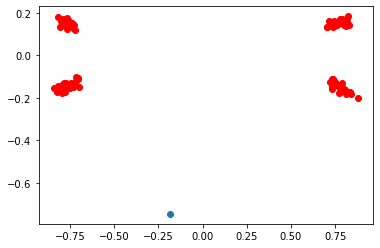

In [16]:
for i in range(iterations):

    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

plt.scatter(X[0,0], X[0,1])

# DropConnect bootstrap

In [97]:
Ncommunities = 2

B = tfp.distributions.Beta(1/3, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.1*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.2777591 , 0.00055017],
       [0.00055017, 0.1927552 ]], dtype=float32)>

In [98]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.70436099, 0.29563901])>

In [99]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

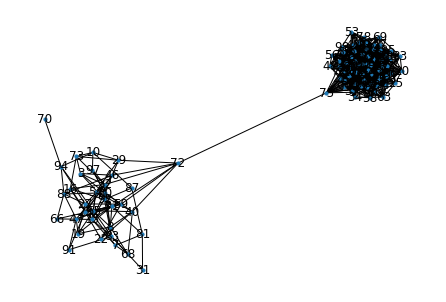

In [100]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [106]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [127]:
def dropconnect_bootstrap(iterations, p, A, d):

    p_list = []
    q_list = []
    hatX_list = []

    # A_neigh = tf.cast(tf.einsum("ik,kj->ij", A, A)>1, dtype = tf.float32)
    p, q, hatX = d_spectral_tensorly(A, d)
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    for i in range(iterations):
        
        Xi = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(),     dtype = tf.float32)
        M  = tf.cast(tfp.distributions.Bernoulli(probs = p).sample(A.shape), dtype = tf.float32)

        p, q, hatX = d_spectral_tensorly(M*Xi + (1-M)*A, d)

        p_list.append(p)
        q_list.append(q)
        hatX_list.append(hatX)

    return p_list, q_list, hatX_list



In [142]:
iterations = 100
d = 2

p     = 1

p_list, q_list, hatX_list = dropconnect_bootstrap(iterations, p, A, d)


In [143]:
i = 0

p, q, hatX = p_list[i], q_list[i], hatX_list[i]
newsimulator = GRDPG(p, q, N)
hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

for i in range(1, iterations):

    p, q, hatX = p_list[i], q_list[i], hatX_list[i]
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

    hatMsample = tf.concat((hatMsample, hatM), axis = 2)


In [144]:
M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

In [145]:
quantileshatM = np.quantile(hatMsample.numpy(), q = (0.025, 0.975), axis = 2)

In [146]:
print("the empirical coverage of the 0.95 credible interval is "+str((tf.reduce_sum(tf.cast(M>quantileshatM[0,:,:], dtype = tf.float32)*tf.cast(M<quantileshatM[1,:,:], dtype = tf.float32))/(M.shape[0]*M.shape[1])).numpy()))

the empirical coverage of the 0.95 credible interval is 0.960929


In [147]:
individual_0 = [hatX_list[i][0,:].numpy() for i in range(iterations)]

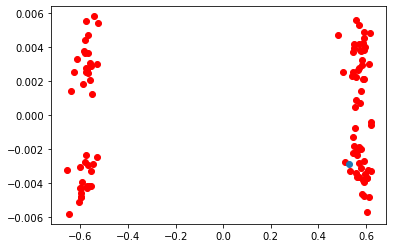

In [148]:
for i in range(iterations):

    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

plt.scatter(X[0,0], X[0,1])